In [229]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from matplotlib.ticker import LogFormatter 
from scipy.optimize import curve_fit
from pathlib import Path
import matplotlib.colors

Для задачи про кривой кубок (стр 54):

In [230]:
# 0 - симметричный кубик
# 1 - кривой кубик

#матрица переходов между скрытыми состояниями:
A =  np.array([[0.95, 0.05], [0.1, 0.9]])
#A =  np.array([[0.5, 0.5], [0.8, 0.2]])

m = A.shape[0] #число скрытых состояний

n = 6 #Вариантов открытых состояний 

#Матрица эмиссий - открытые состояния из скрытых:
B = np.ones((m, n))
B[0, :] = B[0, :]/6
B[1, :] = B[1, :]/10
B[1, 5] = 0.5


#Начальное распределение состояний:
p = np.ones(m)/m
#p = np.array([1, 0])

In [231]:
def generate_sample(A, B, p0, L=350):
    n = B.shape[1]
    m = A.shape[0]
    hidden_seq = np.zeros(L, dtype = int)
    open_seq = np.zeros(L, dtype = int)
    
    hidden_seq[0] = np.random.choice(m, p =p0)
    
    open_seq[0] = np.random.choice(n, p =B[hidden_seq[0]])
    for i in range(1, L):
        hidden_seq[i] = np.random.choice(m, p = A[hidden_seq[i-1]])
     
        open_seq[i] =  np.random.choice(n, p =B[hidden_seq[i]])
    
    return hidden_seq, open_seq

In [232]:
hidden_seq, open_seq = generate_sample(A, B, p)
initvalue = hidden_seq[0]
 

In [233]:
def Viterbi(A, B, p0, open_seq):
    
    L = len(open_seq)   
    m = A.shape[0]
    v = np.zeros((m, L))
    ptr = np.zeros((L, m)) #
    
    #Вроде мы знаем начальное распределение типов кубика, а не идет от определенного состояния 
    #v[:, 0] = np.log(p0) + np.log(B[:, open_seq[0]]) 
    v[initvalue, 0] =  1#np.log(np.multiply(p0, B[:, open_seq[0]]))
    
    for i in range(1, L):
        #вероятность эмиссионная + переход
        v[:,i] = np.log(B[:, open_seq[i]]) + np.max(v[:,i-1].T + np.log(A.T), axis = 1) #check A 
        ptr[i, :] = np.argmax(v[:,i-1].T + np.log(A.T), axis = 1) #check axis 
  
    hidden_seq = np.zeros(L, dtype=int)
    hidden_seq[-1] = np.argmax(v[:, -1])
    for i in range(L - 1, 0, -1):
        hidden_seq[i - 1] = ptr[i, hidden_seq[i]]
    
    return hidden_seq

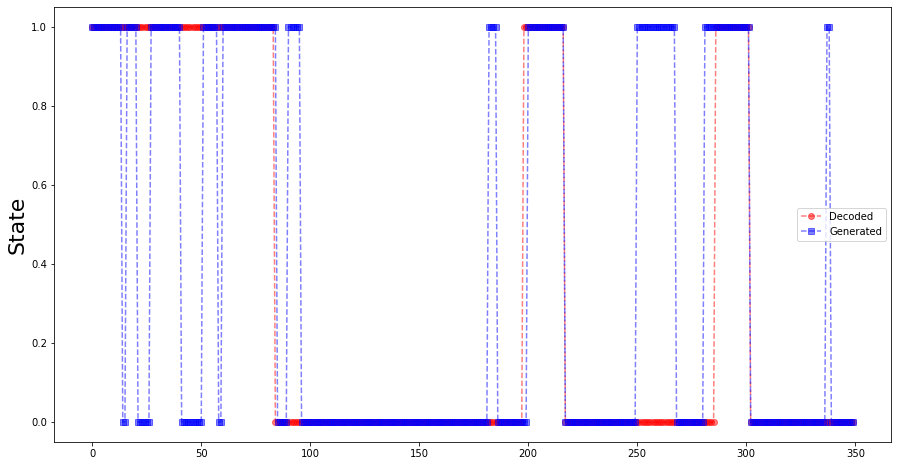

In [234]:
#A =  np.array([[0.8, 0.2], [0.1, 0.9]])
decoded = Viterbi(A, B, p, open_seq)
     
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
 
plt.plot(decoded, "o--", alpha = 0.5, c="r", label =  "Decoded")
plt.plot(hidden_seq, "s--", alpha = 0.5, c = "b", label = "Generated")

plt.ylabel(r"State", fontsize=22)

plt.legend()

In [235]:
def forward(A, B, p0, open_seq):
    m = A.shape[0]
    T = len(open_seq)
    f = np.zeros((T + 1, m))
    f[0, initvalue] = 1#np.log(p0) + np.log(B[:, open_seq[0]])
    #f[0,  open_seq[0] ] = 1
    log_px = 0.
    for t in range(1, T + 1):
        f[t] = B[:,  open_seq[t - 1]] * np.dot(f[t - 1], A)
        pt = f[t].sum()
        #print(f[t], pt)
        f[t] = f[t]/pt
        log_px += np.log(pt)
        #print(log_px)
    return f, log_px
 

In [236]:
def backward(A, B, p0, open_seq):
    T = len(open_seq)
    m = A.shape[0]
    b = np.zeros((T + 1, m))
    b[T, :] = 1
    log_px = 0.
    for t in range(T, 0, -1):
        b[t - 1] = np.dot(A, b[t] * B[:, open_seq[t - 1]])
        pt = b[t - 1].sum()
        b[t - 1]  = b[t - 1] / pt
        log_px += np.log(pt)
        #print(log_px)
    log_px += np.log(b[0, initvalue])
    return b, log_px    

In [247]:
def forward(A, B, p0, open_seq):
    T = len(open_seq)
    m = A.shape[0]
    f = np.zeros((m, T))
    f[:, 0] = np.log(p0) + np.log(B[:,open_seq[0]])
    for i in range(1, T):
        for l in range(m):
            log1 = f[0, i - 1] + np.log(A[0, l])
            log2 = np.log(1 + np.exp(f[1, i - 1] + np.log(A[1, l]) - log1))
            log_sum = log1 + log2
            f[ l, i] = np.log(B[ l, open_seq[i]]) + log_sum
    f_probs = f[0, -1] #+ np.log(1 + np.exp(f[1, -1] - f[0, -1]))
    return np.exp(f), f_probs

def backward(A, B, p0, open_seq):
    T = len(open_seq)
    m = A.shape[0]
    b = np.zeros((m, T))
    b[:, -1] = 1
    for i in range(T - 2, -1, -1):
        for k in range(m):
            log1 = b[0, i + 1] + np.log(A[k, 0]) + np.log(B[0, open_seq[i + 1]])
            log2 = np.log(1 + np.exp(b[1, i + 1] + np.log(A[k, 1]) + np.log(B[1, open_seq[i + 1]]) - log1))
            b[k, i] = log1 + log2
    log1 = b[0, 1] + np.log(p0[0]) + np.log(B[0, open_seq[1]])
    log2 = np.log(1 + np.exp(b[1, 1] + np.log(p0[1]) + np.log(B[1, open_seq[1]]) - log1))
    b_probs = log1#+ log_term2
    return np.exp(b), b_probs

(350, 2)


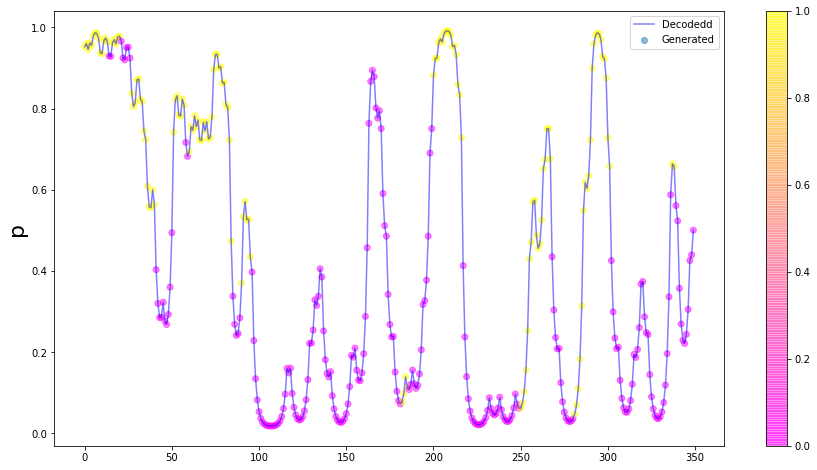

In [248]:
f, fdecoded = forward(A, B, p, open_seq)

b, bdecoded = backward(A, B, p, open_seq)

#print(bdecoded, fdecoded)
        
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
 
#print(len(post_probs[:, 0]), len(hidden_seq))
#plt.scatter(np.arange(len(hidden_seq)),hidden_seq,  alpha = 0.5, c=hidden_seq, label =  "Generated", cmap = "spring")
gamma = f[:-1, :] * b[:-1, :]
gamma = (f*b).T
print(gamma.shape)
gamma /= np.sum(gamma, axis=1, keepdims=True)
plt.scatter(np.arange(len(hidden_seq)), gamma[:,1],  alpha = 0.5, c=hidden_seq, label =  "Generated", cmap = "spring")

plt.plot(np.arange(len(hidden_seq)),gamma [:,1], "-", alpha = 0.5, c = "b", label = "Decodedd")

#plt.xlabel(r' $ \% $', fontsize = 22)
plt.ylabel(r"p", fontsize=22)

plt.legend()

plt.colorbar()

In [252]:
#https://habr.com/ru/post/188244/
def baum_welch(A, B, p0, seq):
    seq = seq
    T = len(seq)
    n_states = A.shape[0]
    kesi = np.zeros((T , n_states, n_states))
    log_px = None
    i = 0
    n_emissions = B.shape[1]
    while True:
        i += 1
        alpha, alpha_log_px = forward(A, B, p0, seq)
        alpha = alpha.T
 
        #print(alpha)
        #if log_px!=None and (np.abs(log_px - alpha_log_px) < np.abs(1e-6*log_px)):
            #break
        beta, beta_log_px = backward(A, B, p0, seq)
        beta = beta.T
        if(i>100):
            break
        log_px = alpha_log_px
        gamma = alpha*beta
        gamma = gamma/np.sum(gamma, axis=1, keepdims=True)
        #print(len(seq), beta.shape)
        for t in range(1, T-1):
            kesi[t] = np.outer(alpha[t], beta[t + 1] * B[:,seq[t]]) * A
        kesi[1:T] = kesi[1:T]/kesi[1:T].sum(axis=(1, 2), keepdims=True)
        #print(kesi[1:T].sum(axis=0)/gamma[1:T].sum(axis=0)[:,np.newaxis])
        A = kesi[1:T].sum(axis=0)/gamma[1:T].sum(axis=0)[:,np.newaxis]
        #print(A)
        obs = np.zeros((T , n_emissions))
        obs[np.arange(0, T ), seq] = 1
        B = np.dot(gamma[1:].T, obs[1:])/gamma[1:].sum(axis=0)[:,np.newaxis]
        print(i, end = " ")
 
    return log_px, A, B

In [253]:
A0 = np.array([[0.9, 0.1],[ 0.1, 0.9]])

In [ ]:
log_px, A1, B1 = baum_welch(A0, B0, p,open_seq)
A1